In [1]:
%matplotlib inline

In [15]:
import random
import numpy as np
import keras
import os
import zipfile
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model


Install rarfile to extract the data

In [16]:
!pip install rarfile

Extraindo os dados

### link para o dataset: https://www.microsoft.com/en-us/download/details.aspx?id=54765. 

### IMPORTANTE: 
O dataset original está no formato .zip, porém tive problemas com esse formato no ambiente do 
google colab, por isso tive que extrair manualmente o conteúdo e compactar a pasta PetImages com o formato .rar e enviar para o colab
para então fazer a extração com o código abaixo.

In [3]:
import rarfile

# se certifica de que o unrar está instalado no ambiente
!apt-get install unrar -y

# Caminho para o arquivo .rar
rar_path = "/content/PetImages.rar"

# Diretório onde os arquivos serão extraídos
extract_path = "/extracted_files"
os.makedirs(extract_path, exist_ok=True)

# Extração do arquivo .rar
try:
    with rarfile.RarFile(rar_path) as rar_ref:
        rar_ref.extractall(extract_path)
    print(f"Arquivos extraídos com sucesso em: {extract_path}")
except rarfile.RarCannotExec as e:
    print("Certifique-se de que o utilitário 'unrar' está instalado e configurado corretamente.")
    print(f"Erro: {e}")
except Exception as e:
    print("Ocorreu um erro durante a extração do arquivo .rar.")
    print(f"Erro: {e}")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Arquivos extraídos com sucesso em: /extracted_files


In [17]:
# verifica as categorias
root = '/extracted_files/PetImages'

train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['/extracted_files/PetImages/Dog', '/extracted_files/PetImages/Cat']


In [18]:
# helper function to get image, input it and input vector
def get_image(path):
  img = image.load_img(path, target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return img, x

In [19]:
# load all the images
batch_size = 500  # Define o tamanho de cada batch
data = []  # Lista para armazenar os dados processados

for c, category in enumerate(categories):
    # Obtemos todas as imagens na categoria
    images = [
        os.path.join(dp, f) for dp, dn, filenames in os.walk(category) for f in filenames
        if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']
    ]

    # Processamos as imagens em batches
    # Utiliza apenas uma parte do dataset para não esgotar a memória do sistema (aproximadamente 1/4 do dataset original)
    for i in range(0, 2200, batch_size):
        batch_images = images[i:i + batch_size]  # Seleciona o batch atual
        print(f"Processando batch {i // batch_size + 1} com {len(batch_images)} imagens")

        for img_path in batch_images:
            try:
                # Verifica se o arquivo é uma imagem válida
                with Image.open(img_path) as img:
                    img.verify()  # Testa se a imagem está íntegra
                    img.close()

                # Carrega a imagem novamente (já validada) para processar
                img, x = get_image(img_path)
                data.append({"X": np.array(x[0]), "Y": c})

            except Exception as e:
                print(f"Erro ao processar a imagem: {img_path}. Erro: {e}")

        # Opcional: libera memória ao final do processamento do batch (caso necessário)
        print(f"Batch {i // batch_size + 1} processado.")

# Conta o número de classes (deve ser 2)
num_classes = len(categories)
print(f"Total de classes: {num_classes}")

Processando batch 1 com 500 imagens
Batch 1 processado.
Processando batch 2 com 500 imagens
Erro ao processar a imagem: /extracted_files/PetImages/Dog/11675.jpg. Erro: Operation on closed image
Batch 2 processado.
Processando batch 3 com 500 imagens
Erro ao processar a imagem: /extracted_files/PetImages/Dog/8730.jpg. Erro: Operation on closed image
Batch 3 processado.
Processando batch 4 com 500 imagens
Erro ao processar a imagem: /extracted_files/PetImages/Dog/4367.jpg. Erro: Operation on closed image
Batch 4 processado.
Processando batch 5 com 500 imagens
Erro ao processar a imagem: /extracted_files/PetImages/Dog/10747.jpg. Erro: Operation on closed image
Erro ao processar a imagem: /extracted_files/PetImages/Dog/7133.jpg. Erro: Operation on closed image
Batch 5 processado.
Processando batch 1 com 500 imagens
Erro ao processar a imagem: /extracted_files/PetImages/Cat/3491.jpg. Erro: Operation on closed image
Batch 1 processado.
Processando batch 2 com 500 imagens
Batch 2 processado.


In [13]:
from IPython.display import clear_output

# Reiniciar todas as variáveis
%reset -f

# Limpar a saída do notebook
clear_output()

print("Memória no Google Colab liberada.")


NameError: name 'clear_output' is not defined

In [20]:
random.shuffle(data)

### Cria as divisões de training/validation/test (70%,15%,15%)

In [21]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [22]:
x_train, y_train = np.array([t["X"] for t in train]), [t["Y"] for t in train]
x_val, y_val = np.array([t["X"] for t in val]), [t["Y"] for t in val]
x_test, y_test = np.array([t["X"] for t in test]), [t["Y"] for t in test]
print(y_test)

[1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 

In [23]:
# normaliza os dados
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# converte os rótulos de categorias para vetores one-hot
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(749, 2)


In [24]:
# sumário
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 4992 images from 2 categories
train / validation / test split: 3494, 749, 749
training data shape:  (3494, 224, 224, 3)
training labels shape:  (3494, 2)


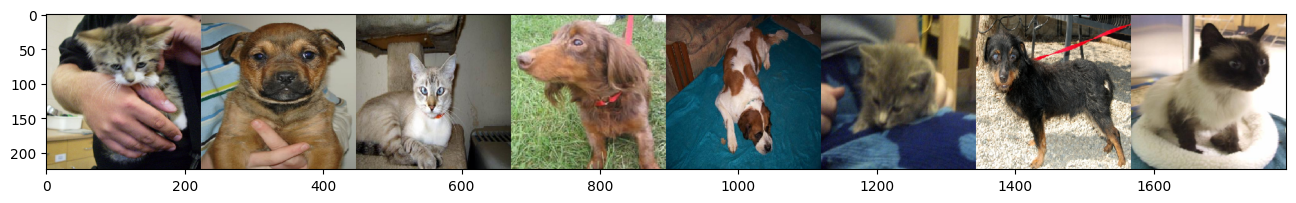

In [25]:
# exibe algumas imagens
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### Aprendizado com rede criada do zero, sem transfer learning

In [26]:
# cria a rede
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# compila o modelo para usar categorical cross-entropy loss function e adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 736ms/step - accuracy: 0.5240 - loss: 0.7068 - val_accuracy: 0.6208 - val_loss: 0.6331
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.5954 - loss: 0.6456 - val_accuracy: 0.6462 - val_loss: 0.6193
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.6507 - loss: 0.6227 - val_accuracy: 0.6916 - val_loss: 0.5882
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.6764 - loss: 0.5916 - val_accuracy: 0.7156 - val_loss: 0.5467
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.7239 - loss: 0.5419 - val_accuracy: 0.7303 - val_loss: 0.5312
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.7343 - loss: 0.5317 - val_accuracy: 0.7503 - val_loss: 0.5156
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.7396 - loss: 0.5202 - val_accuracy: 0.7356 - val_loss: 0.5243
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.7560 - loss: 0.4856 - val_accuracy: 

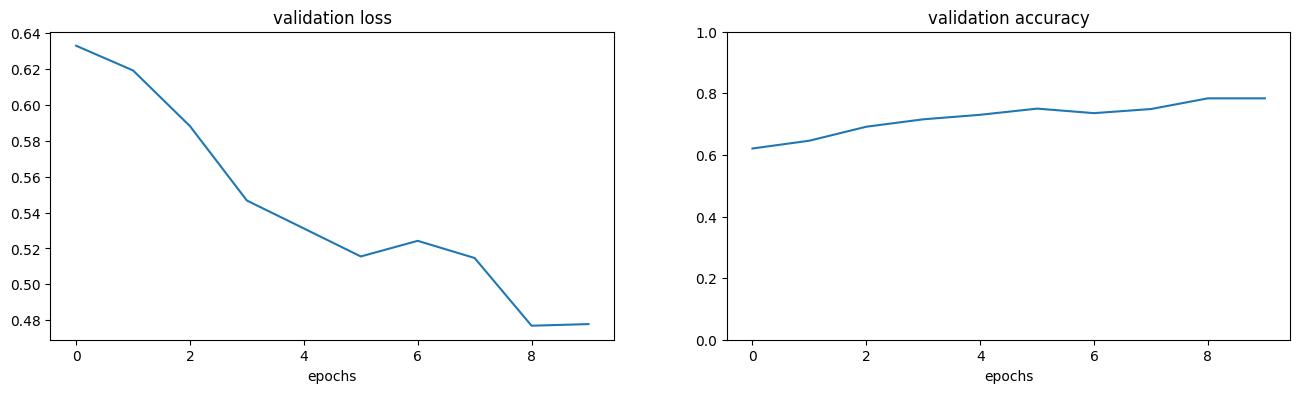

In [28]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

### Treinamento com transfer learning utilizando a rede VGG16 pré-treinada na ImageNet

In [29]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# referencia a camada de input da rede VGG
inp = vgg.input

# cria uma nova camada softmax com num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# conecta a nossa nova camada à penúltima camada no VGG e faz uma referência a ela
out = new_classification_layer(vgg.layers[-2].output)

# cria uma nova rede entre a entrada e saída
model_new = Model(inp, out)


In [32]:
# congela os pesos de todas as camadas, menos a última
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# garante que a última camada é treinável
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [33]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.5886 - loss: 0.7955 - val_accuracy: 0.7957 - val_loss: 0.4439
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 56s 662ms/step - accuracy: 0.8176 - loss: 0.4266 - val_accuracy: 0.8798 - val_loss: 0.3401
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 688ms/step - accuracy: 0.8659 - loss: 0.3466 - val_accuracy: 0.8865 - val_loss: 0.3018
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 681ms/step - accuracy: 0.8819 - loss: 0.3116 - val_accuracy: 0.8945 - val_loss: 0.2933
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 734ms/step - accuracy: 0.8776 - loss: 0.2889 - val_accuracy: 0.9092 - val_loss: 0.2612
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 670ms/step - accuracy: 0.8946 - loss: 0.2771 - val_accuracy: 0.8825 - val_loss: 0.2642
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 741ms/step - accuracy: 0.8920 - loss: 0.2677 - val_accuracy: 0.9119 - val_loss: 0.2448
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 679ms/step - accuracy: 0.9007 - loss: 0.2479 - val_accura

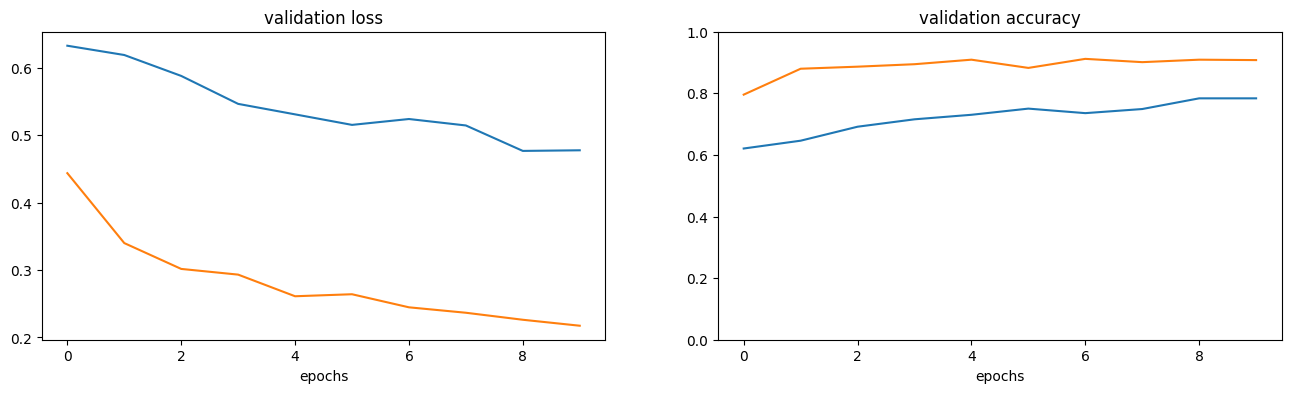

In [34]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [35]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.22188927233219147
Test accuracy: 0.9078771471977234


Pdemos ver que o modelo pré-treinado obteve um resultado significativamente melhor do que o modelo treinado do zero com pesos aleatórios, alcançando uma acurácia de 90% no conjunto de validação

### Salvando o modelo treinado

In [37]:
model_new.save('cats_and_dogs_vgg16.keras')


In [38]:
!zip model_new.zip cats_and_dogs_vgg16.keras  # Substitua pelo nome do arquivo gerado


  adding: cats_and_dogs_vgg16.keras (deflated 7%)
